# :Autoencoder Implementation

To implement the autoencoder, we chose Pytorch for its similarity to numpy and compatibility to gpus.

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
import pandas as pd
from scipy.sparse import coo_matrix

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Test Matrix

Test Matrix below was used to debug and test the performance before applying it to the actual matrix.
The matrix is a sparse integer matrix of 100 users by 50 items.

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Create a user-item interaction matrix (100 users, 50 items) with sparsity
num_users = 10000
num_items = 500
interaction_matrix = np.random.randint(0, 6, size=(num_users, num_items))  # Random interactions from 0 to 5

# Introduce sparsity by setting a high percentage of interactions to 0
sparsity = 0.8  # 80% of the interactions will be set to 0
mask = np.random.rand(*interaction_matrix.shape) < sparsity
interaction_matrix[mask] = 0


In [3]:
class SparseDataset(Dataset):
    def __init__(self, coo_matrix):
        self.data = torch.tensor(coo_matrix.data, dtype=torch.float32)
        self.row = torch.tensor(coo_matrix.row, dtype=torch.long)
        self.col = torch.tensor(coo_matrix.col, dtype=torch.long)
        self.shape = coo_matrix.shape

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.row[idx], self.col[idx], self.data[idx]

In [4]:
def convert_df_coo(df):
    user_mapping = {user_id: idx for idx, user_id in enumerate(df['User_id'].unique())}
    book_mapping = {book_id: idx for idx, book_id in enumerate(df['book_id'].unique())}
    
    # Map the User_id and book_id columns to their integer indices
    df['user_idx'] = df['User_id'].map(user_mapping)
    df['book_idx'] = df['book_id'].map(book_mapping)
    
    # Create the COO matrix
    row = df['user_idx'].values
    col = df['book_idx'].values
    data = df['review/score'].values
    num_users = len(user_mapping)
    num_books = len(book_mapping)
    
    coo = coo_matrix((data, (row, col)), shape=(num_users, num_books))
    return coo

In [5]:
class AutoEncoder(nn.Module):
	def __init__(self, input_dim, bottleneck_size, device='cpu'):
		super(AutoEncoder, self).__init__()
		self.device = device
		self.encoder = nn.Sequential(
			nn.Linear(input_dim, 128),
			nn.ReLU(),
			nn.Linear(128, 64),
			nn.ReLU(),
			nn.Linear(64, bottleneck_size)
		)
		self.decoder = nn.Sequential(
			nn.Linear(bottleneck_size, 64),
			nn.ReLU(),
			nn.Linear(64, 128),
			nn.ReLU(),
			nn.Linear(128, input_dim)
		)
	
	def forward(self, x):
		x = self.encoder(x)
		x = self.decoder(x)
		return x
    
	def fit(self, batches, input_dim, n_epochs=100, min_delta=0.0001, lr=0.001, patience=10):

		optimizer = torch.optim.Adam(self.parameters(), lr=lr)
		criterion = nn.MSELoss()
		best_loss = float('inf')
		patience_counter = 0
		epoch_losses = []
		epochs = []
		for epoch in range(n_epochs):
			epoch_loss = 0.0
			for row, col, value in batches:
				row, col, value = row.to(self.device), col.to(self.device), value.to(self.device)
                
                # Create an input vector with the same length as the number of unique columns
				input_vector = torch.zeros((len(row), input_dim), device=self.device)
				input_vector[torch.arange(len(row)), col] = value
                
				optimizer.zero_grad()
				output = self.forward(input_vector)
                
                # Compute the loss only on the known values
				loss = criterion(output[torch.arange(len(row)), col], value)
				loss.backward()
				optimizer.step()
				epoch_loss += loss.item()
        
			epoch_loss /= len(batches)

			if epoch_loss < best_loss - min_delta:
				best_loss = epoch_loss
				patience_counter = 0
			else:
				patience_counter += 1

			if patience_counter >= patience:
				print(f"Early stopping at epoch {epoch+1} with loss {epoch_loss:.4f}")
				break
			epoch_losses.append(epoch_loss)
			epochs.append(epoch+1)
			print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}')
		return epochs, epoch_losses


In [15]:
def fit_by_bottleneck(user_ratings: pd.DataFrame, device: torch.device, bottleneck: int = 10):

    # Create the COO matrix
    coo = convert_df_coo(user_ratings)
    dataset = SparseDataset(coo)
    model = AutoEncoder(coo.shape[1], 10, device=device).to(device)
    batch_size = 128
    
    batches = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    epochs, losses = model.fit(batches, coo.shape[1], n_epochs=200, lr=0.001, patience=20)
    
    pd.DataFrame({"epochs": epochs, "training losses": losses}).to_csv(f'sample_model/{bottleneck}.csv')
    torch.save(model, f'models/model/model_k={bottleneck}.pt')
    torch.save(model.state_dict(), f'models/weights/smodel_k_weights_{bottleneck}.pt')

In [7]:
# coo = coo_matrix(interaction_matrix, (num_users, num_items))
# dense_matrix = torch.tensor(coo.data(), dtype=torch.float32).to(device)
# dataset = TensorDataset(dense_matrix)
# bottleneck_size = 32
# batch_size = 128
# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model = AutoEncoder(num_items, bottleneck_size, device=device).to(device)

In [8]:
import matplotlib.pyplot as plt

In [9]:
# # Train the model
# epochs, epoch_losses = model.fit(train_loader, min_delta=0.001, n_epochs=1000, lr=0.001, patience=10)

# # Plot the training loss over epochs
# plt.plot(epochs, epoch_losses, label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss over Epochs')
# plt.legend()
# plt.show()

### Training the autoencoders

We then trained the model using LambdaLab's nvidia A10 gpu VM instance. 

In [10]:
model = None

Note: `testing_mode` is a checkpoint variable to signify that we are testing the model on the local end. If set to false, it will train the model.

In [11]:
testing_mode = False

In [12]:
user_ratings = pd.read_csv('ratings_user_tagged.csv.gzip', compression='gzip')
# user_ratings = user_ratings.fillna(0)

In [13]:
user_ratings

,Unnamed: 0,User_id,review/score,book_id
0,1,A30TK6U7DNS82R,5.0,0826414346
1,3,A2MVUWT453QH61,4.0,0826414346
2,5,A2F6NONFUDB6UK,4.0,0826414346
3,6,A14OJS0VWMOSWO,5.0,0826414346
4,11,A373VVEU6Z9M0N,5.0,0829814000
...,...,...,...,...
406027,34950,A2PK3NTC9RMEF4,3.0,0786182431
406028,34958,A32ZKBXJJ45BRY,3.0,B00085PL4C
406029,34967,A25JH6CO4DVINS,4.0,0255364520
406030,34969,AOFGOUMXLMVZS,4.0,B000NSLVCU


In [14]:
user_ratings['User_id'].unique().shape[0]

6842

After training on colab, we utilized the pytorch imports the weights and the model architecture into the 
model.

To see if there is a significant difference between bottlenecks, we decided to run it with different bottlenecks.

In [17]:
bottlenecks = [16]

For training, we used the batch size of 128 and parameters of 1000 epoch, learning rate of 0.001.

In [18]:
import os
if testing_mode:
	print('Tested')
# check if folder exists
# elif os.path.isdir('models'):
# 	model = torch.load('amazon_model.pt')
# 	model.load_state_dict(torch.load('amazon_model_weights.pt'))
else:
    batch_size = 128
    for bottleneck in bottlenecks:
        print(f"=== training k={bottleneck} model ===\n")
        os.makedirs('models', exist_ok=True)
        os.makedirs('models/weights', exist_ok=True)
        os.makedirs('models/model', exist_ok=True)
        fit_by_bottleneck(user_ratings, device, bottleneck)
        print(f"=== training k={bottleneck} model complete===")


=== training k=16 model ===

Epoch [1/200], Loss: 6.0190
Epoch [2/200], Loss: 1.5349
Epoch [3/200], Loss: 0.8493
Epoch [4/200], Loss: 0.7627
Epoch [5/200], Loss: 0.6280
Epoch [6/200], Loss: 0.5494
Epoch [7/200], Loss: 0.4556
Epoch [8/200], Loss: 0.4256
Epoch [9/200], Loss: 0.3695
Epoch [10/200], Loss: 0.3435
Epoch [11/200], Loss: 0.3082
Epoch [12/200], Loss: 0.2886
Epoch [13/200], Loss: 0.2609
Epoch [14/200], Loss: 0.2482
Epoch [15/200], Loss: 0.2282
Epoch [16/200], Loss: 0.2179
Epoch [17/200], Loss: 0.2035
Epoch [18/200], Loss: 0.1932
Epoch [19/200], Loss: 0.1825
Epoch [20/200], Loss: 0.1747
Epoch [21/200], Loss: 0.1652
Epoch [22/200], Loss: 0.1567
Epoch [23/200], Loss: 0.1517
Epoch [24/200], Loss: 0.1420
Epoch [25/200], Loss: 0.1378
Epoch [26/200], Loss: 0.1297
Epoch [27/200], Loss: 0.1267
Epoch [28/200], Loss: 0.1194
Epoch [29/200], Loss: 0.1164
Epoch [30/200], Loss: 0.1111
Epoch [31/200], Loss: 0.1062
Epoch [32/200], Loss: 0.1033
Epoch [33/200], Loss: 0.0988
Epoch [34/200], Loss: 0

In [ ]:
torch.cuda.empty_cache()

In [19]:
from numpy import linalg

In [20]:
# def test_sample_model(model: AutoEncoder, interaction_matrix: pd.DataFrame, device: torch.device, sample_size: int = 10):
# 	model.eval()
	
# 	sampled = interaction_matrix.sample(sample_size)
# 	display(sampled)
# 	tested = sampled.apply(lambda row: mask_test_model(model, 0.2, torch.tensor(row.to_numpy(), dtype=torch.float32, device=device)[0], device), axis=0).to_numpy()
# 	# s = torch.tensor(sampled)
# 	return linalg.norm(sampled.to_numpy() - tested, ord='fro'), tested

## Model Performance 

Now, we can test the performance for each model

In [21]:
def get_mappings(df, user_col='User_id', book_col='book_id'):
    """
    Generate mappings from user and book labels to integer indices.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing user and book columns.
    - user_col (str): Name of the user column in the DataFrame.
    - book_col (str): Name of the book column in the DataFrame.
    
    Returns:
    - user_mapping (dict): Mapping from user labels to integer indices.
    - book_mapping (dict): Mapping from book labels to integer indices.
    """
    user_mapping = {user_id: idx for idx, user_id in enumerate(df[user_col].unique())}
    book_mapping = {book_id: idx for idx, book_id in enumerate(df[book_col].unique())}
    
    return user_mapping, book_mapping


In [22]:
def get_value_from_coo(coo, user_label, book_label, user_mapping, book_mapping):
    """
    Get the value from a COO matrix using user and book labels.
    
    Parameters:
    - coo (coo_matrix): The COO matrix.
    - user_label (str): The user label.
    - book_label (str): The book label.
    - user_mapping (dict): Mapping from user labels to integer indices.
    - book_mapping (dict): Mapping from book labels to integer indices.
    
    Returns:
    - value (float or None): The value from the COO matrix, or None if not found.
    """
    user_idx = user_mapping.get(user_label)
    book_idx = book_mapping.get(book_label)
    if user_idx is not None and book_idx is not None:
        # Convert to CSR format to make element access efficient
        coo_csr = coo.tocsr()
        return coo_csr[user_idx, book_idx]
    else:
        return None


In [23]:
def mask_sample(sample_coo, mask_fraction: float, device: torch.device):
    tensor = torch.tensor(sample_coo.toarray(), dtype=torch.float32, device=device)
    tensor = tensor.to(device)
    masked_tensor = tensor.clone()

    # Identify non-zero elements in the tensor
    non_zero_indices = (tensor != 0).nonzero(as_tuple=False)

    # Determine the number of elements to mask
    num_non_zeros = non_zero_indices.size(0)
    num_to_mask = int(mask_fraction * num_non_zeros)

    if num_to_mask > 0:
        # Randomly select indices to mask
        mask_indices = torch.randperm(num_non_zeros)[:num_to_mask]

        # Apply the mask
        masked_tensor[non_zero_indices[mask_indices, 0], non_zero_indices[mask_indices, 1]] = 0

    return masked_tensor

In [24]:
def test_sample_model(model: nn.Module, masked_sample, user_ratings: pd.DataFrame, device: torch.device):
    model.eval()
    sample_coo = convert_df_coo(user_ratings)
    
    # Convert the COO matrix to a dense tensor
    sample_tensor = torch.tensor(sample_coo.toarray(), dtype=torch.float32, device=device)
    
    
    # Get the model's predictions
    with torch.no_grad():
        result_tensor = model(masked_sample).cpu().detach().numpy()
    
    # Extract the non-zero elements from the result tensor
    result_values = result_tensor[sample_coo.row, sample_coo.col]
    
    # Create the result COO matrix using the same row and column indices
    result_coo = coo_matrix((result_values, (sample_coo.row, sample_coo.col)), shape=sample_coo.shape)
    
    # Calculate the RMSE
    mse = np.mean((sample_tensor.cpu().numpy() - result_tensor) ** 2)
    loss = np.sqrt(mse)
    
    return loss, result_coo, sample_coo

In [25]:
def test_bottleneck(user_ratings: pd.DataFrame, masked_sample, device: torch.device, bottleneck: int = 10):
    print(f'Testing bottleneck {bottleneck}')
    if torch.cuda.is_available():
        model = torch.load(f'models/model/model_k={bottleneck}.pt')
        model.load_state_dict(torch.load(f'models/weights/smodel_k_weights_{bottleneck}.pt'))
    else:
        model = torch.load(f'models/model/model_k={bottleneck}.pt', map_location=torch.device('cpu') )
        model.load_state_dict(torch.load(f'models/weights/smodel_k_weights_{bottleneck}.pt', map_location=torch.device('cpu')))
    return test_sample_model(model, masked_sample, user_ratings, device)

In [27]:
# coo = convert_df_coo(user_ratings)
# dataset = SparseDataset(coo)
# model = AutoEncoder(coo.shape[1], 10, device=device).to(device)
# batch_size = 128

# batches = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# epochs, losses = model.fit(batches, n_epochs=1000, lr=0.001, patience=20)

### Results

### Training Loss

In [28]:
import matplotlib.pyplot as plt
def plot_training_loss(bottleneck: int):
	loss = pd.read_csv(f'models/training_losses/{bottleneck}.csv')
	plt.plot(loss['epochs'], loss['training losses'])
	plt.title(f'Training Loss for Bottleneck Size {bottleneck}')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	

For each bottleneck, we found the training loss as show below:

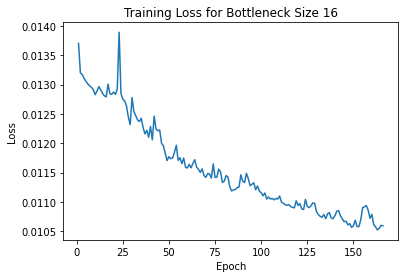

In [29]:
fig, ax = plt.subplots()
for bottleneck in bottlenecks:
	
	plot_training_loss(bottleneck)
	plt.show()

### Performance

We then tested the performances on each bottleneck.

In [30]:
sample_coo = convert_df_coo(user_ratings)
masked_sample = mask_sample(sample_coo, 0.05, device)

We used the masking technique on the rows for each bottleneck.

In [31]:
bottleneck_results = [test_bottleneck(user_ratings, masked_sample, device, k) for k in bottlenecks]
# bottleneck_results = test_bottleneck(user_ratings, device, 5)

Testing bottleneck 16


counted how many rows that match the original one. The resulting `coo_matrix` shows

In [32]:
user_mapping, book_mapping = get_mappings(user_ratings)

In [33]:
# performance_results = pd.DataFrame(columns=['RMSE', 'Non-Zero Count'])
for result in bottleneck_results:
    print(f'RMSE: {result[0]:.4f}')
    user_label = 'A30TK6U7DNS82R'
    book_label = '0826414346'
    value = get_value_from_coo(result[1], user_label, book_label, user_mapping, book_mapping)
    print(f"Predicted for user '{user_label}' and book '{book_label}': {value}")


RMSE: 81.0564
Predicted for user 'A30TK6U7DNS82R' and book '0826414346': 272.91485595703125


In [112]:
user_label = 'A30TK6U7DNS82R'
book_label = '0826414346'
value = get_value_from_coo(sample_coo, user_label, book_label, user_mapping, book_mapping)
print(f"Value for user '{user_label}' and book '{book_label}': {value}")

Value for user 'A30TK6U7DNS82R' and book '0826414346': 5.0


So, the RMSE, the trainig loss and inference in the sample reveals bottleneck size of 16 is the optimal choice.

In [74]:
test16 = False

In [75]:
import pickle
if not test16:
    b16result = bottleneck_results[1]
    pickle.dump(b16result, open('k=16.pkl', 'wb'))
else:
    file = open('k=16.pkl', 'rb')
    b16result = pickle.load(file)
    

In [76]:
b16result

(0.10207582,
 <6842x92327 sparse matrix of type '<class 'numpy.float32'>'
 	with 406032 stored elements in COOrdinate format>,
 <6842x92327 sparse matrix of type '<class 'numpy.float64'>'
 	with 406032 stored elements in COOrdinate format>)

In [77]:
dense_matrix = b16result[1].toarray()
dense_df = pd.DataFrame(dense_matrix, index=user_mapping.keys(), columns=book_mapping.keys())
dense_df

,0826414346,0829814000,0963923080,0854968350,0792391810,0789480662,B000857LFE,1884734766,157067051X,B0007DVHU2,...,0762417137,0970045867,1560540990,1855854929,0425200736,B000O00U1K,0786182431,B00085PL4C,0255364520,B000NSLVCU
A30TK6U7DNS82R,2.815453,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2MVUWT453QH61,0.000778,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2F6NONFUDB6UK,0.001292,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A14OJS0VWMOSWO,3.121191,0.000000,0.0,0.0,0.0,0.0,0.0,3.007054,0.0,0.0,...,3.064209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A373VVEU6Z9M0N,0.000000,0.002893,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A36DPPC53ANNG7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1FAWFMP6CDKG,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATBHMBQEC4063,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1UJ3PQFCT0HRH,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
# dense_df.loc[]["0743491912"]
user_label = "A14OJS0VWMOSWO"
book_label = "1884734766"
value = get_value_from_coo(bottleneck_results[1][1], user_label, book_label, user_mapping, book_mapping)
print(f"Value for user '{user_label}' and book '{book_label}': {value}")
value = get_value_from_coo(sample_coo, user_label, book_label, user_mapping, book_mapping)
print(f"Value for user '{user_label}' and book '{book_label}': {value}")

Value for user 'A14OJS0VWMOSWO' and book '1884734766': 3.5152225494384766
Value for user 'A14OJS0VWMOSWO' and book '1884734766': 5.0


In [114]:
user_label= "A1Z5F7SZDCI5KB"
book_label="B000MCASDU"
value = get_value_from_coo(bottleneck_results[2][1], user_label, book_label, user_mapping, book_mapping)
print(f"Value for user '{user_label}' and book '{book_label}': {value}")
value = get_value_from_coo(sample_coo, user_label, book_label, user_mapping, book_mapping)
print(f"Value for user '{user_label}' and book '{book_label}': {value}")

Value for user 'A1Z5F7SZDCI5KB' and book 'B000MCASDU': 0.03236457705497742
Value for user 'A1Z5F7SZDCI5KB' and book 'B000MCASDU': 2.0


In [ ]:
dense_matrix


### Denoising Autoencoder

### PCA and k-means clustering

So, the data analyis